In [1]:
import torch
import numpy as np
from torch import nn
from skimage.io import imshow
import matplotlib.pyplot as plt
from skimage.io import imshow

In [2]:
import matplotlib

In [3]:
def two_point_interpolation(tensor1, tensor2, t=0.5, do_scale=True):
    assert tensor1.size() == tensor2.size()
    #computes convex combination of 2 points
    scaling_factor = (t**2 + (1 - t)**2)**0.5
    resulting_tensor = (t * tensor1 + (1 - t) * tensor2)
    if do_scale:
  #      print(scaling_factor)
        return resulting_tensor / scaling_factor
    else:
        return resulting_tensor

In [4]:
def n_point_interpolation(value_tensor, coef_tensor, do_scale=True):
    assert coef_tensor.sum(0) == 1
    scaling_factor = (coef_tensor**2).sum(0)**0.5
    resulting_tensor = value_tensor.sum(0)
    if do_scale:
        return resulting_tensor / scaling_factor
    else:
        return resulting_tensor

In [5]:
def vicinity_sampling(initial_tensor, shift_tensor, eps, do_scale=True):
    assert initial_tensor.size() == shift_tensor.size()
    resulting_tensor = initial_tensor + eps * shift_tensor
    scaling_factor = (1 + eps**2)**0.5
    if do_scale:
#       print('scale')
        return resulting_tensor / scaling_factor
    else:
 #       print('no scale')
        return resulting_tensor

In [6]:
def analogies(tensor3, tensor2, tensor1, do_scale=True):
    assert tensor3.size() == tensor2.size() == tensor1.size()
    resulting_tensor = tensor3 + (tensor2 - tensor1)
    scaling_factor = 3**0.5
    if do_scale:
        return resulting_tensor / scaling_factor
    else:
        return resulting_tensor

In [7]:
def gaussian_interpolation(mu_0, sigma_0, mu_1, sigma_1, t=0.5):
    mu_new = t * mu_0 + (1 - t) * mu_1
    
    sigma_0_root = torch.diag(torch.sqrt(Sigma_0))
    sigma_0_root_inv = 1 / sigma_0_root
    sigma_1_root = torch.diag(torch.sqrt(Sigma_1))
    sigma_1_root_inv = 1 / sigma_1_root
    
    middle_part = (t * torch.diag(sigma_0) + 
                   (1 - t) * torch.sqrt(sigma_0_root * sigma_1 * sigma_1_root))**2
        
    sigma_new = sigma_0_root_inv * middle_part * sigma_0_root_inv
    return sigma_new

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
)

In [9]:
def plot_torch_picture(tensor, ax=None):
   # print('tensor shape {}'.format(tensor.size()))
    tensor_to_print = (tensor + 1) / 2
    tensor_to_print = (tensor_to_print * 255).int()
    if ax is None:
#         print(tensor_to_print.squeeze(0).detach().permute(1,2,0))
        plt.imshow(tensor_to_print.squeeze(0).detach().permute(1,2,0).data.numpy())
        plt.axis('off')
        plt.show()
    else:
        ax.axis('off')
#         print(tensor_to_print.squeeze(0).detach().permute(1,2,0).data.numpy())
        ax.imshow(tensor_to_print.squeeze(0).detach().permute(1,2,0).data.numpy())

In [10]:
def draw_interpolation(tensor1, tensor2, n_steps=10, ax=None, do_scale=True):
    ts = torch.linspace(0, 1, steps=n_steps)
    for t in ts:
        yield two_point_interpolation(tensor1, tensor2, t=t, do_scale=do_scale)

In [12]:
ngpu = 1
nz = 100
ngf = 64
ndf = 64
nc = 3

In [14]:
netG = Generator(ngpu=ngpu).to('cpu')
netG.load_state_dict(torch.load('./netG_epoch_24.pth', map_location='cpu'))
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

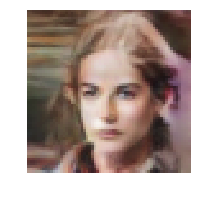

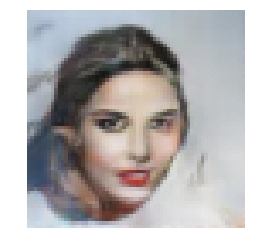

In [33]:
ax = plt.figure(figsize=(3,3)).gca()
rand = torch.randn(1, 100, 1, 1, device='cpu')
rand2 = torch.randn(1, 100, 1, 1, device='cpu')
plot_torch_picture(netG.main(rand))
plot_torch_picture(netG.main(rand2))

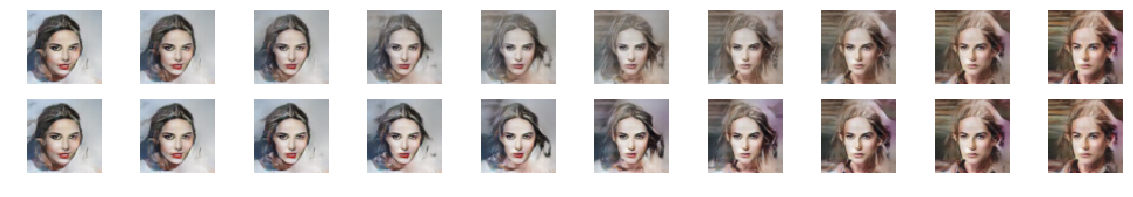

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20, 3))

for index, item in enumerate(draw_interpolation(rand, rand2, do_scale=False)):
    #print(item)
    interpolated = netG.main(item)
    #print((interpolated + 1) /2 )
    plot_torch_picture(interpolated, ax=ax[0, index])

for index, item in enumerate(draw_interpolation(rand, rand2)):
    #print(item)
    interpolated = netG.main(item)
    #print((interpolated + 1) / 2)
    plot_torch_picture(interpolated, ax=ax[1, index])
    
plt.show()

In [23]:
eps = 0.5

rand_shifted_no_scale = vicinity_sampling(rand, torch.zeros_like(rand), eps=eps, do_scale=False)
rand_shifted = vicinity_sampling(rand, torch.zeros_like(rand), eps=eps)

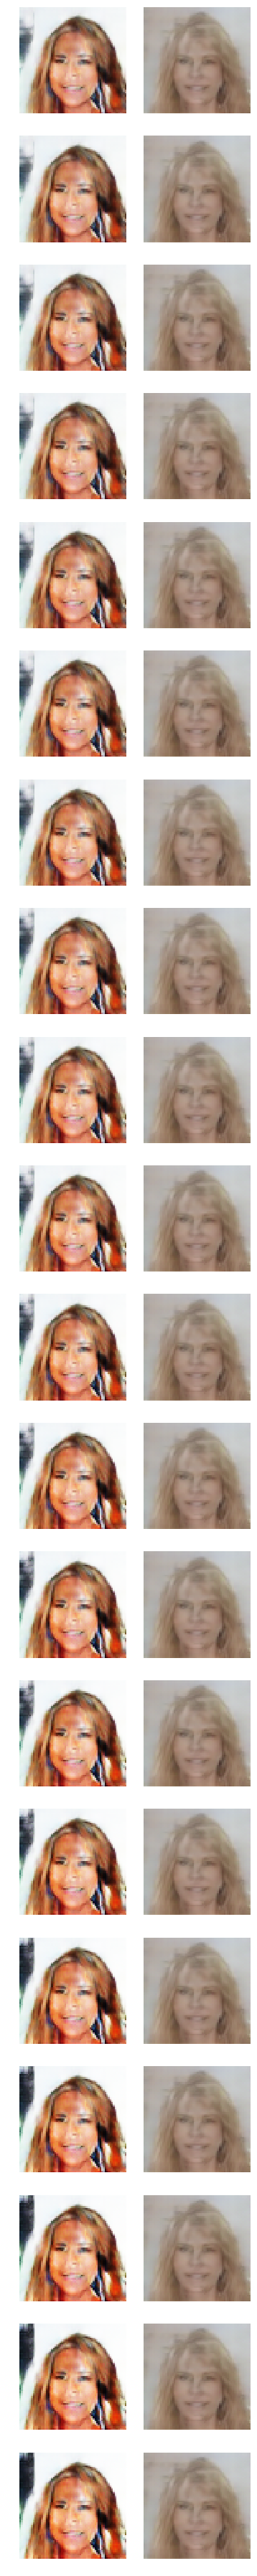

In [35]:
fig, ax = plt.subplots(nrows=20, ncols=2, figsize=(5, 50))
for i in range(20):
    shift = torch.rand_like(rand_shifted) + 0.5
    shift /= torch.norm(shift)
   # print(rand_shifted_no_scale.flatten())
   # print(rand_shifted.flatten())
    rand_shifted_no_scale = vicinity_sampling(rand_shifted_no_scale, shift, eps=eps, do_scale=False)
    rand_shifted = vicinity_sampling(rand_shifted, shift, eps=eps)
    plot_torch_picture(netG.main(rand_shifted_no_scale), ax=ax[i][0])
    plot_torch_picture(netG.main(rand_shifted), ax=ax[i][1])
plt.axis('off')
plt.tight_layout()
plt.show()

tensor(83.3842, grad_fn=<NormBackward0>)
output 1 min:-0.8677838444709778, max:0.9656638503074646
output 2 min:-0.8435721397399902, max:0.8218539357185364


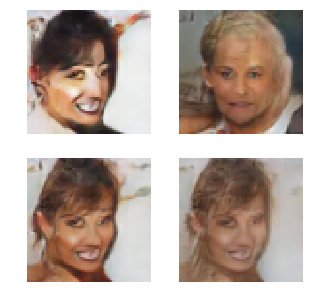

In [50]:
t = 0.5


rand1 = torch.randn(1, 100, 1, 1, device='cpu')
rand2 = torch.randn(1, 100, 1, 1, device='cpu')
interpolation = two_point_interpolation(rand1, rand2, t=t)
interpolation_no_scale = two_point_interpolation(rand1, rand2, do_scale=False, t=t)

output1 = netG.main(rand1)
output2 = netG.main(rand2)

print(torch.norm(output1 - output2))

print('output 1 min:{}, max:{}'.format(output1.min(), output1.max()))
print('output 2 min:{}, max:{}'.format(output2.min(), output2.max()))

fig, ax = plt.subplots(2, 2, figsize=(5,5))


plot_torch_picture(output1, ax[0, 0])
plot_torch_picture(output2, ax[0, 1])
plot_torch_picture(netG.main(interpolation), ax[1, 0])
plot_torch_picture(netG.main(interpolation_no_scale), ax[1, 1])